In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import wandb
import pandas as pd
from pathlib import Path
import os
import re

In [2]:
import matplotlib.font_manager as fm
from pprint import pprint

print("First 10 fonts in cache:")
pprint([f.name for f in fm.fontManager.ttflist[:10]])

print("Is Times New Roman present?",
      any(f.name == "Times New Roman" for f in fm.fontManager.ttflist))

for font in ['times', 'timesi', 'timesbd', 'timesbi']:
    fm.fontManager.addfont(f"/usr/share/fonts/truetype/msttcorefonts/{font}.ttf")

print("First 10 fonts in cache:")
pprint([f.name for f in fm.fontManager.ttflist[:10]])

print("Is Times New Roman present?",
      any(f.name == "Times New Roman" for f in fm.fontManager.ttflist))


First 10 fonts in cache:
['DejaVu Serif Display',
 'STIXSizeThreeSym',
 'cmtt10',
 'DejaVu Serif',
 'STIXSizeOneSym',
 'STIXGeneral',
 'DejaVu Serif',
 'cmmi10',
 'DejaVu Sans',
 'STIXNonUnicode']
Is Times New Roman present? False
First 10 fonts in cache:
['DejaVu Serif Display',
 'STIXSizeThreeSym',
 'cmtt10',
 'DejaVu Serif',
 'STIXSizeOneSym',
 'STIXGeneral',
 'DejaVu Serif',
 'cmmi10',
 'DejaVu Sans',
 'STIXNonUnicode']
Is Times New Roman present? True


In [3]:
# Set publication-quality parameters
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['font.size'] = 10
rcParams['axes.labelsize'] = 10
rcParams['axes.titlesize'] = 12
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['legend.fontsize'] = 8
rcParams['figure.titlesize'] = 12
rcParams['text.usetex'] = False  # Set to True if you have LaTeX installed

colors = ['#0077BB', '#CC3311', '#EE7733', '#EE3377', '#009988', '#33BBEE', '#BBBBBB']
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (1, 1))]
markers = ['o', 's', '^', 'v', 'D', 'p', 'h']
markersizes = [5, 4, 5, 4, 4, 4, 4]

In [4]:
!pwd
data_dir = "../../Figures/Data/Final (21-07-25)"
results_dir = "../../Results"
fig_dir = "../../Figures/"


/mnt/c/Users/wikto/Documents/ETH/Stochastic Concept Bottleneck Models/WSL_SCBM/small_experiments


intervention.*accuracy.*

Alternative method of calculating AUC: Take AUC for each run separately, then calculate std.
This method is better than the previous one, because it doesn't report too high std.

In [56]:
def calculate_intervention_auc(int_acc_data, regex_prefix='', calculate_std=True, normalize=False):
    """
    args:
        normalize: if True, normalize the AUC s.t. it is contained between 0 and 1. Otherwise make the calculations 
        in the same way as it has been initially.
    """    
    # Calculate AUC for all interesting metrics
    # AUC = pd.DataFrame(columns=["policy", "strategy", "y_accuracy", "c_accuracy", "complete_c_accuracy"])
    policies = ['random', 'prob_unc']  # Intervention policies
    strategies = ['hard', 'simple_perc', 'emp_perc', 'conf_interval_optimal']
    metrics = ['y_accuracy', 'c_accuracy', 'complete_c_accuracy']
    all_results = []
    for policy in policies:
        for strategy in strategies:
            result = dict()
            result["policy"] = policy
            result["strategy"] = strategy
            for metric in metrics:
                # print(metric)
                regex = f'{regex_prefix}.*intervention_{strategy}_{policy}/{metric}$'
                filtered = int_acc_data.filter(regex=regex)
                if normalize:
                    AUC_list = np.unique(np.trapz(filtered.to_numpy(),axis=0)) / filtered.to_numpy().shape[0]
                else:    
                    AUC_list = 100 * np.unique(np.trapz(filtered.to_numpy(),axis=0))
                result[metric] = np.mean(AUC_list)
                result[f"{metric}_std"] = np.std(AUC_list)

            all_results.append(result)
    AUC = pd.DataFrame(data=all_results)    
    return AUC
                

In [63]:
model_types = ["CBM", "SCBMg", "SCBMa", "PSCBMg", "PSCBMa", "PSCBMg(i)", "PSCBMe", "PSCBMe03", "PSCBMe005" ]
interventions_data={}
for model in model_types:
    try:
        interventions_data[model] = pd.read_csv(os.path.join(data_dir, f"{model}_intervention_acc_runs.csv"))
        print(f"Data for {model} loaded")
    except FileNotFoundError:
        print(f"No interventions file for model: {model}.")
        interventions_data[model] = None

Data for CBM loaded
Data for SCBMg loaded
Data for SCBMa loaded
Data for PSCBMg loaded
Data for PSCBMa loaded
Data for PSCBMg(i) loaded
Data for PSCBMe loaded
Data for PSCBMe03 loaded
Data for PSCBMe005 loaded


In [64]:
all_AUC = []
normalize=True
for model, data in interventions_data.items():
    if data is not None:
        AUC = calculate_intervention_auc(data, regex_prefix='', normalize=normalize).dropna()
        AUC.insert(0, "model", len(AUC)*[model])
        # print(AUC)
        AUC.to_csv(os.path.join(results_dir, f"{model}_intervention_acc_norm.csv"), float_format="%.4f")
        all_AUC.append(AUC)
all_AUC = pd.concat(all_AUC, ignore_index=True)
print(all_AUC)
all_AUC.to_csv(os.path.join(results_dir, f'all_intervention_acc_norm.csv'), float_format='%.4f')
        

/home/wiktor/miniconda3/envs/scbm/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wiktor/miniconda3/envs/scbm/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/wiktor/miniconda3/envs/scbm/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/wiktor/miniconda3/envs/scbm/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/wiktor/miniconda3/envs/scbm/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/wiktor/miniconda3/envs/scbm/lib/python3

        model    policy               strategy  y_accuracy  y_accuracy_std  \
0         CBM    random                   hard    0.890607        0.001190   
1         CBM  prob_unc                   hard    0.951527        0.000335   
2       SCBMg    random            simple_perc    0.841972        0.000000   
3       SCBMg    random               emp_perc    0.905985        0.000000   
4       SCBMg    random  conf_interval_optimal    0.896253        0.001447   
..        ...       ...                    ...         ...             ...   
57  PSCBMe005    random  conf_interval_optimal    0.737450        0.000909   
58  PSCBMe005  prob_unc                   hard    0.946961        0.000988   
59  PSCBMe005  prob_unc            simple_perc    0.946791        0.000883   
60  PSCBMe005  prob_unc               emp_perc    0.800186        0.005208   
61  PSCBMe005  prob_unc  conf_interval_optimal    0.804861        0.002542   

    c_accuracy  c_accuracy_std  complete_c_accuracy  complete_c

In [15]:
# all_AUC
best_strategies = all_AUC.loc[all_AUC.groupby(["model", "policy"])["y_accuracy"].idxmax()]
bs_full = best_strategies.copy()
best_strategies = best_strategies[["model","policy","strategy"]].copy()
bs = best_strategies
for strategy in best_strategies["strategy"]:
    # print(strategy)
    if strategy == 'simple_perc':
        strategy = 'hard'
bs_full.head(3)


,model,policy,strategy,y_accuracy,y_accuracy_std,c_accuracy,c_accuracy_std,complete_c_accuracy,complete_c_accuracy_std
1,CBM,prob_unc,hard,10752.252324,3.784977,11096.652970,1.515307,9408.330398,27.158682
0,CBM,random,hard,10063.859168,13.444090,10917.942231,5.594273,6002.864992,102.691620
25,PSCBMa,prob_unc,simple_perc,10921.961406,20.204717,11140.948062,3.963446,10007.540298,95.405644


In [9]:
to_drop = [col for col in bs_full.columns if 'complete' in col]
# print(to_drop)
bs_full.drop(to_drop, axis=1, inplace=True)
bs_np = bs_full.to_numpy()


for row in bs_np[:3]:
    print(str(row[3:]))

[10752.2523244222 3.7849765916309237 11096.65296971798 1.5153066042134167]
[10063.859167695045 13.44408962894402 10917.942230900127 5.594272672859767]
[10921.961405873299 20.204716777587368 11140.948062472873
 3.9634461374956063]


In [10]:
print(bs_full.to_latex(float_format='%.2f', index=False, multirow=True, header=False))

\begin{tabular}{lllrrrr}
\toprule
\midrule
CBM & prob_unc & hard & 10752.25 & 3.78 & 11096.65 & 1.52 \\
CBM & random & hard & 10063.86 & 13.44 & 10917.94 & 5.59 \\
PSCBMa & prob_unc & simple_perc & 10921.96 & 20.20 & 11140.95 & 3.96 \\
PSCBMa & random & conf_interval_optimal & 10328.02 & 12.00 & 11011.25 & 4.80 \\
PSCBMe & prob_unc & simple_perc & 10803.49 & 3.59 & 11082.99 & 0.32 \\
PSCBMe & random & simple_perc & 9966.16 & 8.84 & 10754.17 & 1.34 \\
PSCBMe005 & prob_unc & hard & 10700.66 & 11.16 & 11035.18 & 5.28 \\
PSCBMe005 & random & simple_perc & 9790.14 & 31.39 & 10642.90 & 25.69 \\
PSCBMe03 & prob_unc & hard & 10786.18 & 2.33 & 11076.12 & 1.33 \\
PSCBMe03 & random & hard & 9922.46 & 8.40 & 10734.61 & 2.14 \\
PSCBMg & prob_unc & hard & 10938.24 & 3.29 & 11141.02 & 0.60 \\
PSCBMg & random & hard & 10261.21 & 16.09 & 10966.76 & 2.43 \\
PSCBMg(i) & prob_unc & simple_perc & 10970.14 & 1.96 & 11138.54 & 0.35 \\
PSCBMg(i) & random & simple_perc & 10001.44 & 7.97 & 10793.30 & 2.31 \\
SC

In [11]:
print(bs.to_latex(float_format='%.2f', header=['Model', 'Policy', 'Best Strategy'], index=False, multirow=True))

NameError: name 'bs' is not defined

/tmp/ipykernel_92157/1856619226.py:91: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Figure for PSCBMg generated and saved.


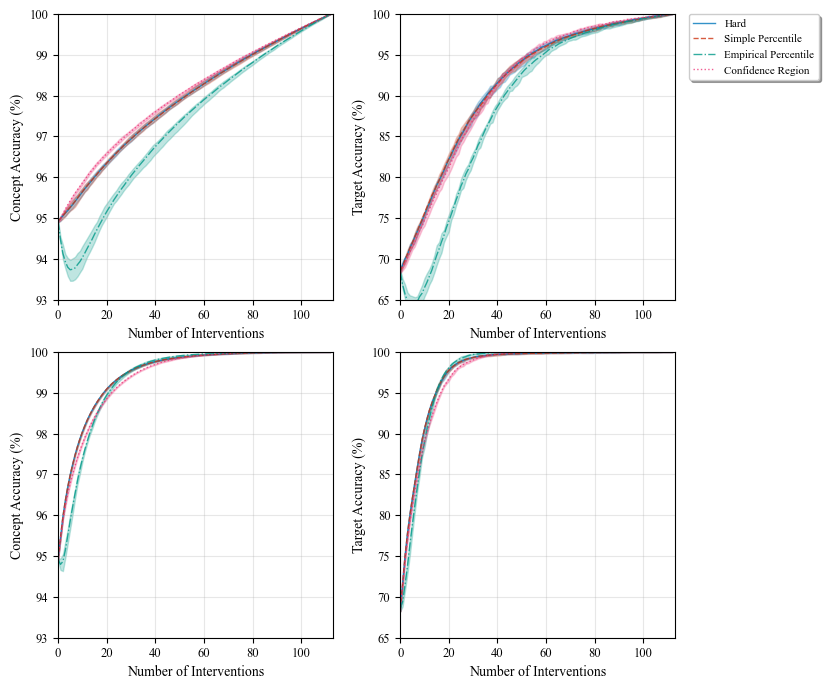

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

colors = ['#0077BB', '#CC3311', '#EE7733', '#EE3377', '#009988', '#33BBEE', '#BBBBBB']
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (1, 1))]
markers = ['o', 's', '^', 'v', 'D', 'p', 'h']
markersizes = [5, 4, 5, 4, 4, 4, 4]

model = 'PSCBMg'
title = False

metrics = ['c_accuracy', 'y_accuracy']  # Target and Concept Accuracy
policies = ['random', 'prob_unc']  # Intervention policies
strategies = ['hard', 'simple_perc', 'emp_perc', 'conf_interval_optimal']
# Define subplot titles
policy_titles = ['Random Policy', 'Concept Uncertainty Policy']
strategy_names = ['Hard', 'Simple Percentile', 'Empirical Percentile', 'Confidence Region']
metric_titles = ['Concept Accuracy (%)', 'Target Accuracy (%)']
n_interventions = np.arange(0, 113)
markerevery = 0.1
data = interventions_data[model]
for row, policy in enumerate(policies):
    for col, metric in enumerate(metrics):
        ax = axes[row, col]
        
        # Plot each model
        for i, strategy in enumerate(strategies):
            regex_prefix=''
            regex = f'{regex_prefix}.*intervention_{strategy}_{policy}/{metric}'
            filtered = 100 * data.filter(regex=f"{regex}$").to_numpy().squeeze()
            # column_max = 100 * data.filter(regex=f"{regex}__MAX$").to_numpy().squeeze()
            # column_min = 100 * data.filter(regex=f"{regex}__MIN$").to_numpy().squeeze()
            if filtered.size != 0:
                column_mean = filtered.mean(axis=1)
                column_std = filtered.std(axis=1)
                column_max = filtered.max(axis=1)
                column_min = filtered.min(axis=1)
                assert column_mean.shape == n_interventions.shape, \
                    f"Shape mismatch: {column_mean.shape} vs {n_interventions.shape} in {model},{metric},{policy}"
            # Plot line with error bars
            # ax.errorbar(n_interventions, column_mean, yerr=column_err,
            #         label=strategy_names[i], color=colors[i], linestyle=linestyles[i],
            #         # marker=markers[i], markersize=markersizes[i], 
            #         # markevery=markerevery, 
            #         errorevery=10,
            #         capsize=3, capthick=1, 
            #         linewidth=1.5, alpha=0.8)
                ax.plot(n_interventions, column_mean, label=strategy_names[i], color=colors[i], linestyle=linestyles[i],
                        linewidth=1, alpha=0.8)
                ax.fill_between(n_interventions, column_min, column_max, color=colors[i], alpha=0.25)
                
        # Customize axes
        ax.set_xlabel('Number of Interventions')
        # if col == 0:
        ax.set_ylabel(metric_titles[col])
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 113)
        
        # # Set y-axis limits based on metric type and model

        if re.match("PSCBMe", model): 
            if metric == 'c_accuracy':  # Concept Accuracy
                ax.set_ylim(0, 100)
            else:  # Target Accuracy
                ax.set_ylim(0, 100)
        else:
            if metric == 'c_accuracy':  # Concept Accuracy
                ax.set_ylim(93, 100)
            else:  # Target Accuracy
                ax.set_ylim(65, 100)

        # Add policy title only to top row
        # if row == 0:
        #     ax.set_title(policy_titles[col], pad=10)
        
        # Add legend only to the top-right subplot
        if row == 0 and col == 1:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                    borderaxespad=0, frameon=True, fancybox=True, shadow=True)

# Adjust layout to prevent overlap
if title:
    fig.suptitle(f"Comparison of all intervention strategies for model: {model}")
fig.tight_layout()
fig.subplots_adjust(top=0.85, right=0.85)
if title:
    fig.savefig(os.path.join(fig_dir, f'{model}_all_strategies_title.pdf'), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(fig_dir, f'{model}_all_strategies_title.png'), dpi=300, bbox_inches='tight')
else:
    fig.savefig(os.path.join(fig_dir, f'{model}_all_strategies.pdf'), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(fig_dir, f'{model}_all_strategies.png'), dpi=300, bbox_inches='tight')
fig.show()
print(f"Figure for {model} generated and saved.")




In [29]:
PSCBMe = ["PSCBMe", "PSCBMe005", "PSCBMe03"]
part_PSCBMe_data = {}
for model in PSCBMe:
    print(model)
    data = pd.read_csv(os.path.join(data_dir, f"{model}_intervention_acc.csv"))
    part_PSCBMe_data[model] = data
    print(f"Data for {model} loaded")
    AUC = calculate_intervention_auc(data, regex_prefix='').dropna()
    print(AUC)
    AUC.to_csv(os.path.join(results_dir, f"{model}_intervention_acc.csv"), float_format="%.2f")

PSCBMe
Data for PSCBMe loaded
     policy               strategy    y_accuracy  y_accuracy_std  \
0    random                   hard   9964.488171             0.0   
1    random            simple_perc   9965.378447             0.0   
2    random               emp_perc   8462.538825             0.0   
3    random  conf_interval_optimal   8504.695465             0.0   
4  prob_unc                   hard  10802.613324             0.0   
5  prob_unc            simple_perc  10803.790790             0.0   
6  prob_unc               emp_perc   9439.234069             0.0   
7  prob_unc  conf_interval_optimal   9427.394714             0.0   

     c_accuracy  c_accuracy_std  complete_c_accuracy  complete_c_accuracy_std  
0  10754.287181             0.0          2221.171793                      0.0  
1  10754.119566             0.0          2221.914897                      0.0  
2  10236.350194             0.0           785.687776                      0.0  
3  10228.766200             0.0      

In [53]:
print(bs)

        model    policy               strategy
1         CBM  prob_unc                   hard
0         CBM    random                   hard
25     PSCBMa  prob_unc            simple_perc
23     PSCBMa    random  conf_interval_optimal
41     PSCBMe  prob_unc            simple_perc
37     PSCBMe    random            simple_perc
56  PSCBMe005  prob_unc                   hard
53  PSCBMe005    random            simple_perc
48   PSCBMe03  prob_unc                   hard
44   PSCBMe03    random                   hard
16     PSCBMg  prob_unc                   hard
12     PSCBMg    random                   hard
33  PSCBMg(i)  prob_unc            simple_perc
29  PSCBMg(i)    random            simple_perc
11      SCBMa  prob_unc  conf_interval_optimal
7       SCBMa    random               emp_perc
5       SCBMg  prob_unc               emp_perc
3       SCBMg    random               emp_perc


CBM/hard
SCBMa/emp_perc
PSCBMg/hard
PSCBMa/conf_interval_optimal
PSCBMg(i)/simple_perc
PSCBMe/simple_perc
CBM/hard
SCBMa/emp_perc
PSCBMg/hard
PSCBMa/conf_interval_optimal
PSCBMg(i)/simple_perc
PSCBMe/simple_perc


/tmp/ipykernel_92157/61223368.py:86: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Figure generated and saved.


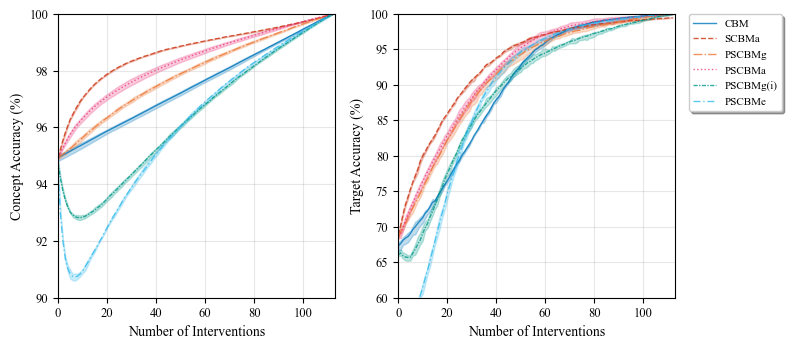

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

colors = ['#0077BB', '#CC3311', '#EE7733', '#EE3377', '#009988', '#33BBEE', '#BBBBBB']
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (1, 1))]
markers = ['o', 's', '^', 'v', 'D', 'p', 'h']
markersizes = [5, 4, 5, 4, 4, 4, 4]


models = ['CBM', 'SCBMa', 'PSCBMg', 'PSCBMa', 'PSCBMg(i)', 'PSCBMe']
# models = ['PSCBMe', 'PSCBMe03', 'PSCBMe005']
title = False

metrics = ['c_accuracy', 'y_accuracy']  # Target and Concept Accuracy
policies = ['random', 'prob_unc']  # Intervention policies
strategies = ['hard', 'simple_perc', 'emp_perc', 'conf_interval_optimal']
# Define subplot titles
policy_titles = ['Random Policy', 'Concept Uncertainty Policy']
strategy_names = ['Hard', 'Simple Percentile', 'Empirical Percentile', 'Confidence Region']
metric_titles = ['Concept Accuracy (%)', 'Target Accuracy (%)']
n_interventions = np.arange(0, 113)
markerevery = 0.1
data = interventions_data[model]
policy = 'random'
for col, metric in enumerate(metrics):
    ax = axes[col]
    
    # Plot each model
    for i, model in enumerate(models):
        data = interventions_data[model]
        strategy = bs.loc[bs["model"]==model].loc[bs["policy"]==policy]['strategy'].values[0]
        print(f"{model}/{strategy}")
        regex_prefix=''
        regex = f'{regex_prefix}.*intervention_{strategy}_{policy}/{metric}'
        filtered = 100 * data.filter(regex=f"{regex}$").to_numpy().squeeze()
        # column_max = 100 * data.filter(regex=f"{regex}__MAX$").to_numpy().squeeze()
        # column_min = 100 * data.filter(regex=f"{regex}__MIN$").to_numpy().squeeze()
        if filtered.size != 0:
            column_mean = filtered.mean(axis=1)
            column_std = filtered.std(axis=1)
            column_max = filtered.max(axis=1)
            column_min = filtered.min(axis=1)
            assert column_mean.shape == n_interventions.shape, \
                f"Shape mismatch: {column_mean.shape} vs {n_interventions.shape} in {model},{metric},{policy}"
        # Plot line with error bars
        # ax.errorbar(n_interventions, column_mean, yerr=column_err,
        #         label=strategy_names[i], color=colors[i], linestyle=linestyles[i],
        #         # marker=markers[i], markersize=markersizes[i], 
        #         # markevery=markerevery, 
        #         errorevery=10,
        #         capsize=3, capthick=1, 
        #         linewidth=1.5, alpha=0.8)
            ax.plot(n_interventions, column_mean, label=model, color=colors[i], linestyle=linestyles[i],
                    linewidth=1, alpha=0.8)
            ax.fill_between(n_interventions, column_min, column_max, color=colors[i], alpha=0.25)
            
    # Customize axes
    ax.set_xlabel('Number of Interventions')
    # if col == 0:
    ax.set_ylabel(metric_titles[col])
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 113)
    
    # # Set y-axis limits based on metric type and model

    if metric == 'c_accuracy':  # Concept Accuracy
        ax.set_ylim(90, 100)
    else:  # Target Accuracy
        ax.set_ylim(60, 100)
    
    # Add legend only to the top-right subplot
    if col == 1:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                borderaxespad=0, frameon=True, fancybox=True, shadow=True)

# Adjust layout to prevent overlap
if title:
    fig.suptitle(f"Comparison of all models for Random policy.")
fig.tight_layout()
fig.subplots_adjust(top=0.85, right=0.85)
if title:
    fig.savefig(os.path.join(fig_dir, f'{policy}_all_models_title.pdf'), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(fig_dir, f'{policy}_all_models_title.png'), dpi=300, bbox_inches='tight')
else:
    fig.savefig(os.path.join(fig_dir, f'{policy}_all_models.pdf'), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(fig_dir, f'{policy}_all_models.png'), dpi=300, bbox_inches='tight')
fig.show()
print(f"Figure generated and saved.")




findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

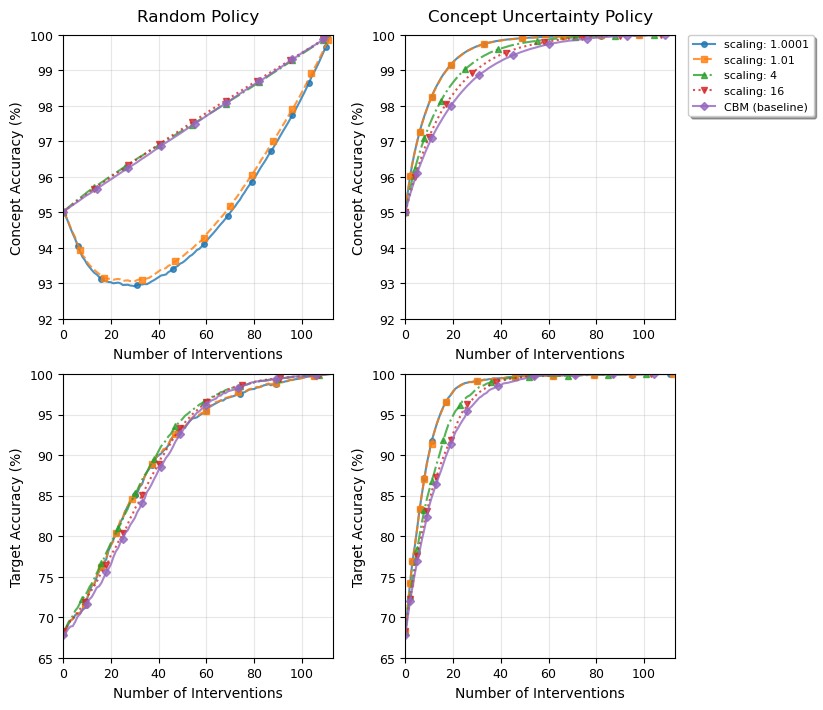

In [ ]:
"""
Plot performance of PSCBM with various scalings in comparison to CBM. 
I want to make the point that strong scaling moves us towards vanilla CBM performance.
SCBM doesn't need to be plotted here. It will be later.
Use random and prob_unc policy with hard strategy.
For each policy plot performance of hard and conf_interval_optimal intervention strategies.
Notably, for CBM I can only use hard in both figures,
and for SCBM I will use simple_perc instead of hard.
"""
# Load the data
%pwd
all_data = pd.read_csv("../../Figures/Data/PSCBM-scalings-comp.csv")
# Top panel: concept
# Bottom panel: target
fig, axes = plt.subplots(2, 2, figsize=(8,8))
# fig.suptitle('Concept and Target Accuracy for empirical covariance PSCBM with different scaling of the off-diagonal elements.', 
#              fontsize=14, y=0.95)

metrics = ['c_accuracy', 'y_accuracy']  # Target and Concept Accuracy
policies = ['random', 'prob_unc']  # Intervention policies
# Define subplot titles
policy_titles = ['Random Policy', 'Concept Uncertainty Policy']
metric_titles = ['Concept Accuracy (%)', 'Target Accuracy (%)']
scalings=['1.0001', '1.01', '4', '16'] # Remove some of them for clarity
n_interventions = np.arange(0, 113)
markerevery = 0.1
# Plot data
for row, metric in enumerate(metrics):
    for col, policy in enumerate(policies):
        ax = axes[row, col]
        
        # Plot each scaling
        for i, scaling in enumerate(scalings):
            column_mean = 100 * all_data.filter(regex=f".*{scaling}.*hard_{policy}.*{metric}$").to_numpy().squeeze()
            column_max = 100 * all_data.filter(regex=f".*{scaling}.*hard_{policy}.*{metric}__MAX$").to_numpy().squeeze()
            column_min = 100 * all_data.filter(regex=f".*{scaling}.*hard_{policy}.*{metric}__MIN$").to_numpy().squeeze()
            column_err = column_max - column_min
            assert column_mean.shape == n_interventions.shape, \
                f"Shape mismatch: {column_mean.shape} vs {n_interventions.shape}"
            assert column_err.shape == n_interventions.shape, f"Shape mismatch: {column_mean.shape} vs {n_interventions.shape}"
            if False and np.any(column_err != 0):
            # Plot line with error bars
                ax.errorbar(n_interventions, column_mean, yerr=column_err,
                       label=f"scaling: {scaling}", color=colors[i], linestyle=linestyles[i],
                       marker=markers[i], markersize=markersizes[i], 
                       markevery=markerevery, capsize=3, capthick=1, 
                       linewidth=1.5, alpha=0.8)
            else:
                ax.plot(n_interventions, column_mean,
                       label=f"scaling: {scaling}", color=colors[i], linestyle=linestyles[i],
                       marker=markers[i], markersize=markersizes[i], 
                       markevery=markerevery,
                       linewidth=1.5, alpha=0.8)
            
            
        # Plot CBM 
        cbm_mean = 100 * all_data.filter(regex=f".*[^S]CBM.*hard_{policy}.*{metric}$")
        cbm_mean = cbm_mean.to_numpy().squeeze()
        cbm_max = 100 * all_data.filter(regex=f".*[^S]CBM.*hard_{policy}.*{metric}__MAX$").to_numpy().squeeze()
        cbm_min = 100 * all_data.filter(regex=f".*[^S]CBM.*hard_{policy}.*{metric}__MIN$").to_numpy().squeeze()
        cbm_err = cbm_max - cbm_min

        assert cbm_mean.shape == n_interventions.shape, \
            f"Shape mismatch: {cbm_mean.shape} vs {n_interventions.shape}"
        assert cbm_err.shape == n_interventions.shape, f"Shape mismatch: {cbm_err.shape} vs {n_interventions.shape}"
        # print(cbm_mean, cbm_err)
        if False and cbm_err.any() != 0:
            ax.errorbar(n_interventions, cbm_mean, yerr=cbm_err,
                       label=f"CBM (baseline)", color=colors[-1], linestyle=linestyles[-1],
                       marker=markers[-1], markersize=markersizes[-1], 
                       markevery=markerevery, capsize=3, capthick=1, 
                       linewidth=1.5, alpha=0.8)
        else:
            ax.plot(n_interventions, cbm_mean,
                       label=f"CBM (baseline)", color=colors[-1], linestyle=linestyles[-1],
                       marker=markers[-1], markersize=markersizes[-1], 
                       markevery=markerevery, 
                       linewidth=1.5, alpha=0.8)
        
        # Customize axes
        ax.set_xlabel('Number of Interventions')
        # if col == 0:
        ax.set_ylabel(metric_titles[row])
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 113)
        
        # # Set y-axis limits based on metric type
        if metric == 'c_accuracy':  # Concept Accuracy
            ax.set_ylim(92, 100)
        else:  # Target Accuracy
            ax.set_ylim(65, 100)

        # Add policy title only to top row
        if row == 0:
            ax.set_title(policy_titles[col], pad=10)
        
        # Add legend only to the top-right subplot
        if row == 0 and col == 1:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                     borderaxespad=0, frameon=True, fancybox=True, shadow=True)

# Adjust layout to prevent overlap
fig.tight_layout()
fig.subplots_adjust(top=0.85, right=0.85)

# Add caption
# fig.text(0.5, 0.02, 
#          'Results are reported as averages and standard deviations of model performance across ten seeds.',
#          ha='center', fontsize=10, style='italic')

# Save the figure
fig_dir = "../../Figures/"
fig.savefig(f'{fig_dir}PSCBM_scaling_effect.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{fig_dir}PSCBM_scaling_effect.png', dpi=300, bbox_inches='tight')
fig.show()


Plot intervention accuracy for PSCBM with partial data

CBM/hard
SCBMa/conf_interval_optimal
PSCBMe/simple_perc
PSCBMe03/simple_perc
PSCBMe005/simple_perc
CBM/hard
SCBMa/conf_interval_optimal
PSCBMe/simple_perc
PSCBMe03/simple_perc
PSCBMe005/simple_perc


/tmp/ipykernel_84646/1973202902.py:101: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Figure generated and saved.


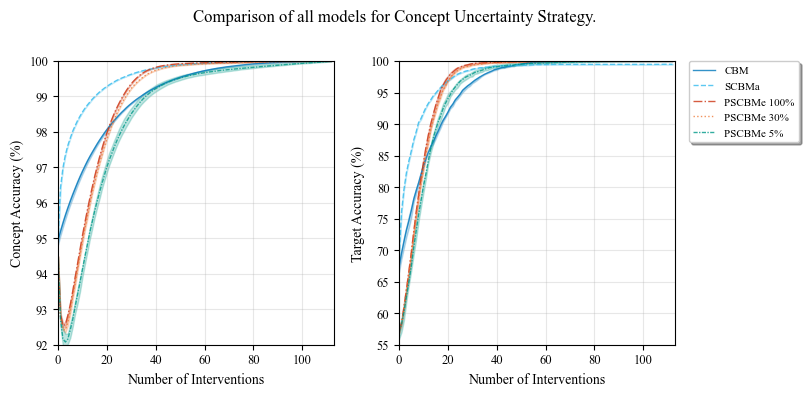

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

colors = ['#0077BB', '#33BBEE', '#CC3311', '#EE7733', '#009988', '#EE3377', '#BBBBBB']
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (1, 1))]
markers = ['o', 's', '^', 'v', 'D', 'p', 'h']
markersizes = [5, 4, 5, 4, 4, 4, 4]


# models = ['CBM', 'SCBMa', 'PSCBMg', 'PSCBMa', 'PSCBMg(i)', 'PSCBMe']
models = ['CBM', 'SCBMa','PSCBMe', 'PSCBMe03', 'PSCBMe005']
title = True

metrics = ['c_accuracy', 'y_accuracy']  # Target and Concept Accuracy
policies = ['random', 'prob_unc']  # Intervention policies
strategies = ['hard', 'simple_perc', 'emp_perc', 'conf_interval_optimal']
# Define subplot titles
policy_titles = ['Random Policy', 'Concept Uncertainty Policy']
strategy_names = ['Hard', 'Simple Percentile', 'Empirical Percentile', 'Confidence Region']
metric_titles = ['Concept Accuracy (%)', 'Target Accuracy (%)']
n_interventions = np.arange(0, 113)
markerevery = 0.1
data = interventions_data[model]
policy = 'prob_unc'
for col, metric in enumerate(metrics):
    ax = axes[col]
    
    # Plot each model
    for i, model in enumerate(models):
        data = interventions_data[model]
        # strategy = bs.loc[bs["model"]==model].loc[bs["policy"]==policy]['strategy'].values[0]
        if model == 'SCBMa':
            strategy = 'conf_interval_optimal' 
        elif model == 'CBM':
            strategy = 'hard'
        else:
            strategy = 'simple_perc'

        if model in ['CBM', 'SCBMa']:
            label = model
        elif model == 'PSCBMe':
            label = "PSCBMe 100%"
        elif model == 'PSCBMe03':
            label = 'PSCBMe 30%'
        elif model == 'PSCBMe005':
            label = 'PSCBMe 5%'
        print(f"{model}/{strategy}")
        regex_prefix=''
        regex = f'{regex_prefix}.*intervention_{strategy}_{policy}/{metric}'
        filtered = 100 * data.filter(regex=f"{regex}$").to_numpy().squeeze()
        # column_max = 100 * data.filter(regex=f"{regex}__MAX$").to_numpy().squeeze()
        # column_min = 100 * data.filter(regex=f"{regex}__MIN$").to_numpy().squeeze()
        if filtered.size != 0:
            column_mean = filtered.mean(axis=1)
            column_std = filtered.std(axis=1)
            column_max = filtered.max(axis=1)
            column_min = filtered.min(axis=1)
            assert column_mean.shape == n_interventions.shape, \
                f"Shape mismatch: {column_mean.shape} vs {n_interventions.shape} in {model},{metric},{policy}"
        # Plot line with error bars
        # ax.errorbar(n_interventions, column_mean, yerr=column_err,
        #         label=strategy_names[i], color=colors[i], linestyle=linestyles[i],
        #         # marker=markers[i], markersize=markersizes[i], 
        #         # markevery=markerevery, 
        #         errorevery=10,
        #         capsize=3, capthick=1, 
        #         linewidth=1.5, alpha=0.8)
            ax.plot(n_interventions, column_mean, label=label, color=colors[i], linestyle=linestyles[i],
                    linewidth=1, alpha=0.8)
            ax.fill_between(n_interventions, column_min, column_max, color=colors[i], alpha=0.25)
            
    # Customize axes
    ax.set_xlabel('Number of Interventions')
    # if col == 0:
    ax.set_ylabel(metric_titles[col])
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 113)
    
    # # Set y-axis limits based on metric type and model

    if metric == 'c_accuracy':  # Concept Accuracy
        ax.set_ylim(92, 100)
    else:  # Target Accuracy
        ax.set_ylim(55, 100)
    
    # Add legend only to the top-right subplot
    if col == 1:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                borderaxespad=0, frameon=True, fancybox=True, shadow=True)

# Adjust layout to prevent overlap
if title:
    fig.suptitle(f"Comparison of all models for Concept Uncertainty Strategy.")
fig.tight_layout()
fig.subplots_adjust(top=0.85, right=0.85)
if title:
    fig.savefig(os.path.join(fig_dir, f'PSCBMe_partial_data_title.pdf'), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(fig_dir, f'PSCBMe_partial_data_title.png'), dpi=300, bbox_inches='tight')
else:
    fig.savefig(os.path.join(fig_dir, f'PSCBMe_partial_data.pdf'), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(fig_dir, f'PSCBMe_partial_data.png'), dpi=300, bbox_inches='tight')
fig.show()
print(f"Figure generated and saved.")





In [ ]:
policy = 'random'
metric = 'complete_c_accuracy'  # Target Accuracy

filtered_data = all_data.filter(regex = f".*PSCBMg.*emp_perc_{policy}/{metric}$")
print(filtered_data.columns)


Index(['PSCBMg(i)-final - intervention_emp_perc_random/complete_c_accuracy'], dtype='object')


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

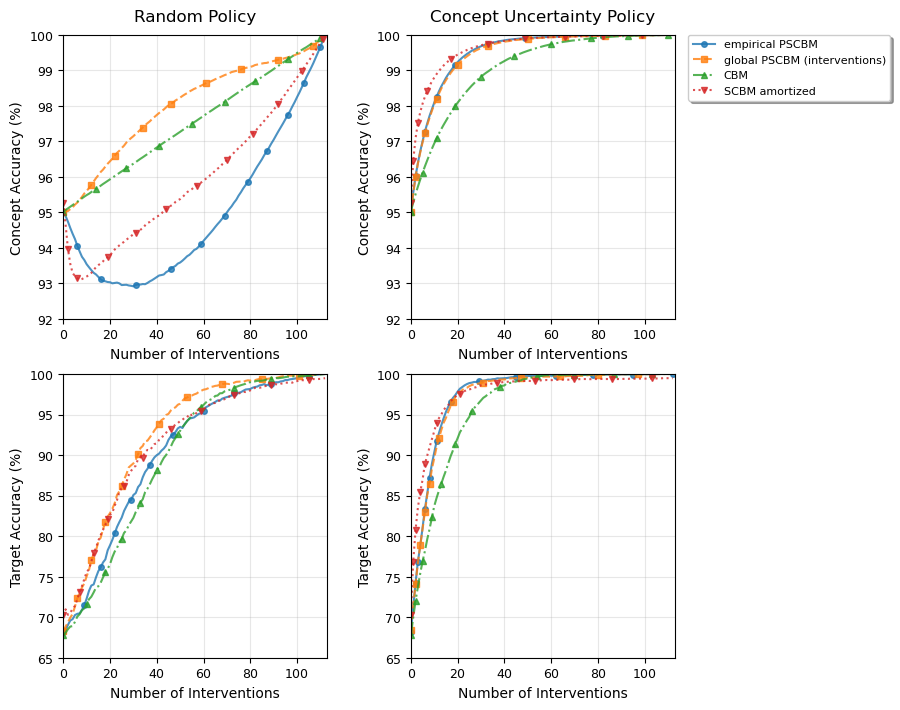

In [ ]:
# Top panel: concept
# Bottom panel: target
all_data = pd.read_csv("../../Figures/Data/PSCBM-final-interventions.csv")
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
# fig.suptitle('Intervention curves of various variants of PSCBM as well as CBM and SCBM as baselines.', 
#              fontsize=14, y=0.95)

models = ['PSCBMe', 'PSCBMg(i)','CBM', 'SCBM']  # Models to compare
model_names = ['empirical PSCBM', 'global PSCBM (interventions)',  'CBM', 'SCBM amortized']  # Model names for legend
metrics = ['c_accuracy', 'y_accuracy']  # Target and Concept Accuracy
policies = ['random', 'prob_unc']  # Intervention policies
strategy = 'hard'
# Define subplot titles
policy_titles = ['Random Policy', 'Concept Uncertainty Policy']
metric_titles = ['Concept Accuracy (%)', 'Target Accuracy (%)']
n_interventions = np.arange(0, 113)
markerevery = 0.1
# Plot data
for row, metric in enumerate(metrics):
    for col, policy in enumerate(policies):
        ax = axes[row, col]
        
        # Plot each model
        for i, model in enumerate(models):
            if model == 'CBM':
                regex = f"^2.*[^S]CBM.*{policy}/{metric}$"
            elif model == 'SCBM':
                regex = f".*[^P]SCBM.*simple_perc_{policy}/{metric}$"
            elif model == "PSCBMe":
                regex = f".*PSCBMe.*{strategy}_{policy}/{metric}$"
            elif model == "PSCBMg(i)":
                regex = f".*PSCBMg\(i\).*{strategy}_{policy}/{metric}$"
            column_mean = 100 * all_data.filter(regex=regex).to_numpy().squeeze()
            column_max = 100 * all_data.filter(regex=f"{regex}__MAX$").to_numpy().squeeze()
            column_min = 100 * all_data.filter(regex=f"{regex}__MIN$").to_numpy().squeeze()
            column_err = column_max - column_min
            assert column_mean.shape == n_interventions.shape, \
                f"Shape mismatch: {column_mean.shape} vs {n_interventions.shape} in {model},{metric},{policy}"
            # assert column_err.shape == n_interventions.shape, f"Shape mismatch: {column_err.shape} vs {n_interventions.shape}"
            if False and np.any(column_err != 0):
            # Plot line with error bars
                ax.errorbar(n_interventions, column_mean, yerr=column_err,
                       label=model_names[i], color=colors[i], linestyle=linestyles[i],
                       marker=markers[i], markersize=markersizes[i], 
                       markevery=markerevery, capsize=3, capthick=1, 
                       linewidth=1.5, alpha=0.8)
            else:
                ax.plot(n_interventions, column_mean,
                       label=model_names[i], color=colors[i], linestyle=linestyles[i],
                       marker=markers[i], markersize=markersizes[i], 
                       markevery=markerevery,
                       linewidth=1.5, alpha=0.8)
        
        # Customize axes
        ax.set_xlabel('Number of Interventions')
        # if col == 0:
        ax.set_ylabel(metric_titles[row])
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 113)
        
        # # Set y-axis limits based on metric type
        if metric == 'c_accuracy':  # Concept Accuracy
            ax.set_ylim(92, 100)
        else:  # Target Accuracy
            ax.set_ylim(65, 100)

        # Add policy title only to top row
        if row == 0:
            ax.set_title(policy_titles[col], pad=10)
        
        # Add legend only to the top-right subplot
        if row == 0 and col == 1:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                     borderaxespad=0, frameon=True, fancybox=True, shadow=True)

# Adjust layout to prevent overlap
fig.tight_layout()
fig.subplots_adjust(top=0.85, right=0.85)

# Add caption
# fig.text(0.5, 0.02, 
#          'Results are reported as averages and standard deviations of model performance across ten seeds.',
#          ha='center', fontsize=10, style='italic')

# Save the figure
fig_dir = "../../Figures/"
fig.savefig(f'{fig_dir}PSCBM_interventions_{strategy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{fig_dir}PSCBM_interventions_{strategy}.png', dpi=300, bbox_inches='tight')
fig.show()


In [37]:
ratio = 1 
scaling_data.filter(regex=f"{ratio}\s.*{strategy}_{policy}.*{metric}$")

,model.covariance_scaling: 1.0001 (PSCBM) - intervention_hard_random/c_accuracy,model.covariance_scaling: 1.001 (PSCBM) - intervention_hard_random/c_accuracy,model.covariance_scaling: 1.01 (PSCBM) - intervention_hard_random/c_accuracy
0,0.950170,0.950170,0.950158
1,0.948947,0.948956,0.949016
2,0.947364,0.947381,0.947490
3,0.945581,0.945604,0.945811
4,0.943951,0.943983,0.944276
...,...,...,...
108,0.993611,0.993673,0.994297
109,0.995115,0.995166,0.995687
110,0.996688,0.996736,0.997100
111,0.998340,0.998363,0.998578


/tmp/ipykernel_92157/3351834981.py:98: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


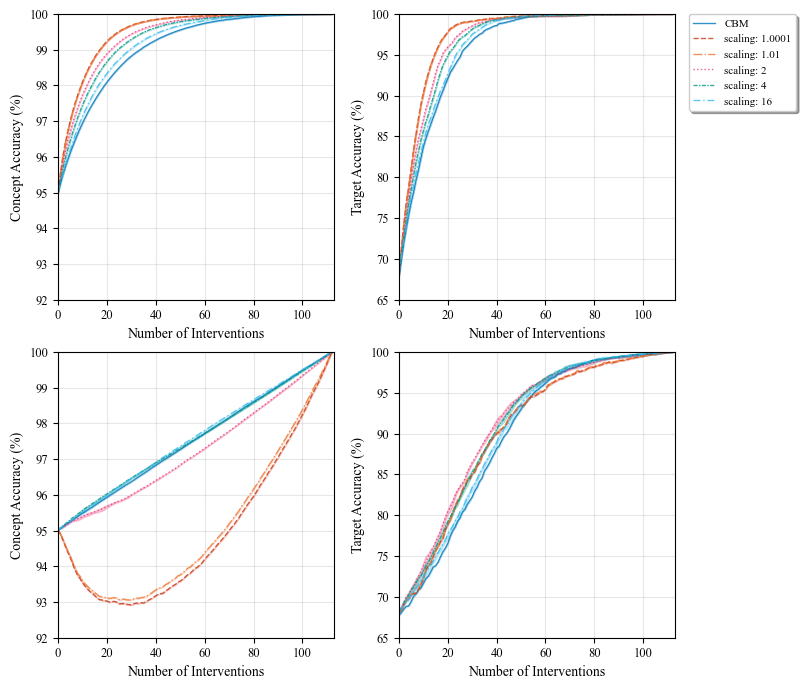

In [45]:
"""
Plot performance of PSCBM with various scalings in comparison to CBM. 
I want to make the point that strong scaling moves us towards vanilla CBM performance.
SCBM doesn't need to be plotted here. It will be later.
Use random and prob_unc policy with hard strategy.
For each policy plot performance of hard and conf_interval_optimal intervention strategies.
Notably, for CBM I can only use hard in both figures,
and for SCBM I will use simple_perc instead of hard.
"""
colors = ['#0077BB', '#CC3311', '#EE7733', '#EE3377', '#009988', '#33BBEE', '#BBBBBB']
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (1, 1))]
# Load the data
%pwd
# scaling_data = pd.read_csv("../../Figures/Data/PSCBM-data-scaling-comp.csv")
scaling_data = pd.read_csv(os.path.join(data_dir, "PSCBM-scalings-comp.csv"))
# Top panel: concept
# Bottom panel: target
fig, axes = plt.subplots(2, 2, figsize=(8,8))
# fig.suptitle('Concept and Target Accuracy for empirical covariance PSCBM with different scaling of the off-diagonal elements.', 
#              fontsize=14, y=0.95)
title = False
metrics = ['c_accuracy', 'y_accuracy']  # Target and Concept Accuracy
policies = ['prob_unc', 'random']  # Intervention policies
strategy = 'hard'
# Define subplot titles
policy_titles = ['Concept Uncertainty Policy', 'Random Policy']
metric_titles = ['Concept Accuracy (%)', 'Target Accuracy (%)']
scalings=['1.0001', '1.01', '2', '4', '16'] # Remove some of them for clarity
n_interventions = np.arange(0, 113)
markerevery = 0.1
# Plot data
for row, metric in enumerate(metrics):
    for col, policy in enumerate(policies):
        ax = axes[col, row]
        
        # Plot CBM 
        cbm_mean = 100 * scaling_data.filter(regex=f".*[^S]CBM.*hard_{policy}.*{metric}$")
        cbm_mean = cbm_mean.to_numpy().squeeze()
        cbm_max = 100 * scaling_data.filter(regex=f".*[^S]CBM.*hard_{policy}.*{metric}__MAX$").to_numpy().squeeze()
        cbm_min = 100 * scaling_data.filter(regex=f".*[^S]CBM.*hard_{policy}.*{metric}__MIN$").to_numpy().squeeze()
        cbm_err = cbm_max - cbm_min

        assert cbm_mean.shape == n_interventions.shape, \
            f"Shape mismatch: {cbm_mean.shape} vs {n_interventions.shape}"
        assert cbm_err.shape == n_interventions.shape, f"Shape mismatch: {cbm_err.shape} vs {n_interventions.shape}"
        # print(cbm_mean, cbm_err)
        ax.plot(n_interventions, cbm_mean, label=f"CBM", color=colors[0], linestyle=linestyles[0],
                        linewidth=1, alpha=0.8)
        ax.fill_between(n_interventions, cbm_min, cbm_max, color=colors[0], alpha=0.25)

        # Plot each scaling
        for i, scaling in enumerate(scalings):
            column_mean = 100 * scaling_data.filter(regex=f".*\s{scaling}\s.*{strategy}_{policy}.*{metric}$").to_numpy().squeeze()
            column_max = 100 * scaling_data.filter(regex=f".*\s{scaling}\s.*{strategy}_{policy}.*{metric}__MAX$").to_numpy().squeeze()
            column_min = 100 * scaling_data.filter(regex=f".*\s{scaling}\s.*{strategy}_{policy}.*{metric}__MIN$").to_numpy().squeeze()
            column_err = column_max - column_min
            assert column_mean.shape == n_interventions.shape, \
                f"Shape mismatch: {column_mean.shape} vs {n_interventions.shape} in {metric},{policy},{scaling}"
            assert column_err.shape == n_interventions.shape, f"Shape mismatch: {column_mean.shape} vs {n_interventions.shape}"
            ax.plot(n_interventions, column_mean, label=f"scaling: {scaling}", color=colors[i+1], linestyle=linestyles[i+1],
                        linewidth=1, alpha=0.8)
            ax.fill_between(n_interventions, column_min, column_max, color=colors[i+1], alpha=0.25)
            
            
        
        
        # Customize axes
        ax.set_xlabel('Number of Interventions')
        # if col == 0:
        ax.set_ylabel(metric_titles[row])
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 113)
        
        # # Set y-axis limits based on metric type
        if metric == 'c_accuracy':  # Concept Accuracy
            ax.set_ylim(92, 100)
        else:  # Target Accuracy
            ax.set_ylim(65, 100)

        # Add policy title only to top row
        # if row == 0:
        #     ax.set_title(policy_titles[col], pad=10)
        
        # Add legend only to the top-right subplot
        if row == 1 and col == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                     borderaxespad=0, frameon=True, fancybox=True, shadow=True)

# Adjust layout to prevent overlap
fig.tight_layout()
fig.subplots_adjust(top=0.85, right=0.85)

if title:
    pass
else:
    fig.savefig(f'{fig_dir}PSCBM_scaling_effect.pdf', dpi=300, bbox_inches='tight')
    fig.savefig(f'{fig_dir}PSCBM_scaling_effect.png', dpi=300, bbox_inches='tight')
fig.show()


In [ ]:
tags = ["PSCBM", "scalings", "interventions", "ratios"]
additional_tags = ["PSCBM_scalings", "PSCBM_interventions", "PSCBM_ratios"]
tags.extend(additional_tags)
print(tags)

['PSCBM', 'scalings', 'interventions', 'ratios', 'PSCBM_scalings', 'PSCBM_interventions', 'PSCBM_ratios']


In [ ]:
cbm_mean


array([ 95.02271414,  95.27313113,  95.50890326,  95.72387338,
        95.92404962,  96.11713886,  96.29604816,  96.4669466 ,
        96.63429856,  96.79332972,  96.94203734,  97.08365202,
        97.21972346,  97.34685421,  97.46567011,  97.57769704,
        97.69096375,  97.7963686 ,  97.89714813,  97.99978137,
        98.09039235,  98.17545414,  98.26421738,  98.34527373,
        98.42278361,  98.49659801,  98.56979847,  98.63606095,
        98.70401621,  98.76627326,  98.82005453,  98.87645841,
        98.92622828,  98.97107482,  99.01776314,  99.07031655,
        99.11068678,  99.15183187,  99.19297695,  99.22857285,
        99.26525354,  99.30269718,  99.33705926,  99.36479926,
        99.39777851,  99.42613244,  99.45294261,  99.47914481,
        99.50657487,  99.53014851,  99.55326319,  99.575454  ,
        99.59748983,  99.6178329 ,  99.63416457,  99.65342879,
        99.67346191,  99.69195724,  99.70813394,  99.7235477 ,
        99.7389555 ,  99.75298047,  99.76699948,  99.77

In [ ]:
def calculate_auc(intervention_curve, normalize=True, weigh=False, weights=None, cutoff=None):
    """
    Calculate the Area Under the Curve (AUC) for a given intervention curve.
    
    Parameters:
    - intervention_curve: A numpy array representing the intervention curve.
    - normalize: If True, normalize the AUC by subtracting the value at 0. 
      This way it only represents the gains from interventions, but not initial performance.
    - weigh: If True, apply weights to the AUC calculation by weighing initial performance 
      gains more. The rationale is that it the most important are improvements after few
      interventions.
    - weights: Weights to apply if weigh is True. If None, a default weighing scheme is applied.
    - cutoff: Optional cutoff value to limit the AUC calculation to some initial interventions.
      If None, the entire intervention curve is used.
    
    Returns:
    - The calculated AUC value.
    """
    if cutoff is not None and cutoff < len(intervention_curve) - 1:
        intervention_curve = intervention_curve[:cutoff+1]
    
    if normalize:
        intervention_curve = intervention_curve - intervention_curve[0]

    intervention_curve = intervention_curve[1:]  # Remove the first value (0 interventions)
    n_interventions = len(intervention_curve)
    
    if weigh:
        if weights is None:
            weights = np.exp(-np.arange(n_interventions) / n_interventions)
        else:
            weights = weights[:n_interventions]
        intervention_curve *= weights
    auc = np.trapz(intervention_curve, dx=1)  # Calculate the AUC using the trapezoidal rule
    
    return auc

In [ ]:
calculate_auc(cbm_mean, normalize=True, weigh=False)  # Why does this result in a negative number?
# It appears that the argument has been modified in place

-7067.929932341176

In [67]:
cbm_mean

array([95.02271414, 95.27313113, 92.98458779, 90.73074727, 88.51743919,
       86.35138009, 84.22558288, 82.14501342, 80.11264732, 78.12361421,
       76.17564698, 74.27065018, 72.40901079, 70.58741322, 68.80565448,
       67.06410502, 65.36737957, 63.70837419, 62.08846829, 60.51083202,
       58.96599095, 57.45729295, 55.98926335, 54.55442209, 53.15440019,
       51.78833168, 50.45702854, 49.15646397, 47.89022205, 46.65388403,
       45.4455475 , 44.26966801, 43.12130802, 42.00063666, 40.90984275,
       39.84972804, 38.81230261, 37.80217408, 36.8183288 , 35.85807776,
       34.92324798, 34.01304615, 33.12553452, 32.25902725, 31.41683985,
       30.5952128 , 29.7946084 , 29.01477448, 28.25569837, 27.51541279,
       26.79439729, 26.09203184, 25.4080368 , 24.74155085, 24.09157674,
       23.45936752, 22.84392406, 22.24428238, 21.65987658, 21.09066248,
       20.53640541, 19.9964364 , 19.47066338, 18.95818883, 18.45934368,
       17.97387552, 17.50060602, 17.03953548, 16.5907657 , 16.15